# Project Introduction

The objective of this project is to build classifiers able to predict, given the network state, at which node(s) requested services need to be processed such that the networks remains in operational conditions. We have at our disposal a dataset that contains 500,000 entries. Each entry contains information regarding the source and destination of a request, as well as a list of requested services, bandwidth and time necessary to process the request. In addition to that, we also have information of the current state of the network, regarding the utilization of each node and link. For each requested service, there is also a list of nodes at which each request will be processed. The latter are the desired variables that we seek to predict.


<img src="https://github.com/guiyrt/AA2/blob/main/images/network.png?raw=true">


The network we are working with provides the following services:

0. Firewall
1. WAN and application acceleration
2. Deep Packet Inspection (DPI)
3. Lawful Intercept (LI)
4. server load balancing
5. NAT44 [RFC3022]
6. NAT64 [RFC6146]
7. NPTv6 [RFC6296]
8. HOST_ID injection
9. HTTP Header Enrichment functions
10. TCP optimizer









# Initial data exploration

This notebook is intended to run on Google Colab, so it's assumed that the dataset is not present in the environment, so we need to fetch it first. So, let's start by cloning the repository, so that we can access the compressed dataset. This is faster than manually uploading the dataset.

In [ ]:
import bz2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# Clone repository
!git clone https://github.com/guiyrt/AA2.git

# Open the file
compressed_dataset = bz2.BZ2File("AA2/dataset.csv.bz2") 

# Read compressed file
data = compressed_dataset.read()

# Write uncompressed file
with open("dataset.csv", 'wb') as f:
  f.write(data)

fatal: destination path 'AA2' already exists and is not an empty directory.


Now we can import the dataset. The dataset uses semicolons as field delimiters and uses the first line as header. Let's use pandas and take a peek into the dataset.


In [ ]:
dataset = pd.read_csv("dataset.csv", sep=";", header=0)
dataset.head()

,id,src,dst,bw,duration,S0,S1,S2,S3,S4,MLU,MNU,E0,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E20,E21,E22,E23,E24,E25,E26,E27,N0,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,RS0,RS1,RS2,RS3,RS4
0,0,2,5,7157.260627,29,2,4,3,-1,-1,0.000000,0.000000,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.000,0.0000,0.0000,7,7,4,-1,-1
1,1,0,7,1360.551508,25,2,-1,-1,-1,-1,0.071909,0.143145,0.0000,0.0,0.0,0.0000,0.0,0.0719,0.0,0.0,0.0,0.0719,0.0,0.0,0.0,0.0000,0.0719,0.0,0.0719,0.0000,0.0,0.0,0.0719,0.0000,0.0,0.0719,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0716,0.0,0.0,0.1431,0.000,0.0000,0.0000,7,-1,-1,-1,-1
2,2,9,3,7592.258826,13,1,-1,-1,-1,-1,0.071909,0.156751,0.0137,0.0,0.0,0.0137,0.0,0.0719,0.0,0.0,0.0,0.0719,0.0,0.0,0.0,0.0000,0.0719,0.0,0.0719,0.0000,0.0,0.0,0.0719,0.0000,0.0,0.0719,0.0000,0.0,0.0137,0.0,0.0,0.0,0.0,0.0,0.0716,0.0,0.0,0.1568,0.000,0.0000,0.0000,9,-1,-1,-1,-1
3,3,10,10,13151.493039,28,2,0,4,3,1,0.148188,0.156751,0.0137,0.0,0.0,0.0137,0.0,0.0719,0.0,0.0,0.0,0.0719,0.0,0.0,0.0,0.0763,0.0719,0.0,0.1482,0.0000,0.0,0.0,0.0719,0.0000,0.0,0.0719,0.0763,0.0,0.0899,0.0,0.0,0.0,0.0,0.0,0.0716,0.0,0.0,0.1568,0.000,0.0759,0.0000,7,8,8,9,10
4,4,6,9,7830.801264,9,0,1,-1,-1,-1,0.222081,0.288266,0.0137,0.0,0.0,0.0137,0.0,0.0719,0.0,0.0,0.0,0.0719,0.0,0.0,0.0,0.0763,0.0719,0.0,0.1482,0.1321,0.0,0.0,0.0719,0.1321,0.0,0.0719,0.2084,0.0,0.2221,0.0,0.0,0.0,0.0,0.0,0.0716,0.0,0.0,0.2883,0.263,0.2074,0.1315,8,9,-1,-1,-1


We can also see some initial information regarding each column by invoking the describe method to the dataFrame as such:

In [ ]:
dataset.describe()

,id,src,dst,bw,duration,S0,S1,S2,S3,S4,MLU,MNU,E0,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E20,E21,E22,E23,E24,E25,E26,E27,N0,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,RS0,RS1,RS2,RS3,RS4
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.0,500000.0,500000.000000,500000.0,500000.000000,500000.0,500000.0,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,249999.500000,4.997794,5.003786,5502.825284,19.753728,2.001212,1.401634,0.800720,0.199972,-0.399524,0.567008,0.694419,0.209454,0.217045,0.209381,0.255371,0.215511,0.368636,0.108130,0.109894,0.107612,0.318024,0.221892,0.317688,0.351118,0.108601,0.221467,0.354183,0.353015,0.356629,0.477990,0.350037,0.356187,0.461117,0.369136,0.459389,0.352197,0.255646,0.477976,0.353722,0.0,0.0,0.467292,0.0,0.558364,0.0,0.0,0.593887,0.546261,0.642268,0.448318,6.759420,5.313620,3.751018,2.148908,0.558086
std,144337.711634,3.161306,3.163196,3302.938857,13.458348,1.414202,1.744439,1.834447,1.718806,1.356563,0.317339,0.400509,0.237599,0.237895,0.239015,0.249263,0.236784,0.252031,0.130945,0.126065,0.130574,0.239988,0.161797,0.239610,0.248746,0.124675,0.160778,0.258766,0.257010,0.256485,0.311581,0.246769,0.256925,0.309591,0.252843,0.308327,0.255693,0.252179,0.310537,0.256842,0.0,0.0,0.324629,0.0,0.353474,0.0,0.0,0.345141,0.317429,0.396099,0.300689,2.651018,3.927114,4.374647,4.196866,3.333992
min,0.000000,0.000000,0.000000,1000.003968,5.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,2.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,124999.750000,2.000000,2.000000,2878.730987,9.000000,1.000000,0.000000,-1.000000,-1.000000,-1.000000,0.333125,0.389228,0.024800,0.039800,0.024300,0.067000,0.039700,0.193600,0.000000,0.000000,0.000000,0.141900,0.098200,0.142300,0.168700,0.000000,0.098200,0.155400,0.155400,0.166600,0.244300,0.168700,0.165400,0.236000,0.194100,0.235400,0.165600,0.066400,0.245500,0.165700,0.0,0.0,0.244900,0.0,0.302100,0.0,0.0,0.325600,0.305300,0.339300,0.229700,4.000000,2.000000,-1.000000,-1.000000,-1.000000
50%,249999.500000,5.000000,5.000000,4746.644735,15.000000,2.000000,1.000000,0.000000,-1.000000,-1.000000,0.458875,0.619673,0.115300,0.122500,0.114500,0.166600,0.120500,0.306000,0.053700,0.060100,0.053800,0.251900,0.195100,0.251900,0.285800,0.060200,0.195000,0.284400,0.284500,0.282300,0.383000,0.286400,0.281200,0.355100,0.304800,0.353800,0.280600,0.165600,0.384600,0.281900,0.0,0.0,0.354800,0.0,0.471700,0.0,0.0,0.533500,0.473200,0.579000,0.352450,7.000000,7.000000,4.000000,-1.000000,-1.000000
75%,374999.250000,8.000000,8.000000,7556.071157,28.000000,3.000000,3.000000,2.000000,1.000000,-1.000000,0.812605,0.888885,0.319400,0.327600,0.317100,0.375500,0.326100,0.530900,0.183400,0.185400,0.182100,0.451600,0.314600,0.450500,0.501200,0.182000,0.315300,0.524400,0.524525,0.521900,0.687500,0.499900,0.522500,0.677000,0.533600,0.677300,0.510200,0.372000,0.688900,0.515900,0.0,0.0,0.697000,0.0,0.803900,0.0,0.0,0.811400,0.770200,0.829500,0.655000,9.000000,9.000000,8.000000,7.000000,-1.000000
max,499999.000000,10.000000,10.000000,14997.998306,59.000000,4.00

Here is some context about each variable:

* **id** : Service request ID
* **src** : Request source node
* **dst** : Request destination node
* **bw** : Requested bandwidth
* **duration** : Time needed to process the request
* **S[0-4]** : Ordered list of requested service functions
* **MLU** : Maximum link utilization
* **MNU** : Maximum Node utilization
* **E[0-27]** : Usage of link
* **N[0-10]** : Usage of node
* **RS[0-4]** : At which node the correspondent requested service will be processed

From the description provided above, we can already tell that some of the columns do not contain useful information, such as some node usage values, but it's always better to confirm it with a proper exploratory analysis. So, let's analyze the dataset, in order to better prepare the data for processing. We can start by looking for missing values and duplicated entries.


In [ ]:
# Check for misssing values
missing_values = np.isnan(dataset.values).any()

# Check if there are
duplicates = dataset.duplicated().any()

print(missing_values, duplicates)

False False


Given the false output, we don't have to worry about neither duplicated nor incomplete data. Next, we can analyze variable distribution using box plots, in case of discrete variables, and countplots in case of categorical variables.

Text(0.5, 1.0, 'Destination node distribution')

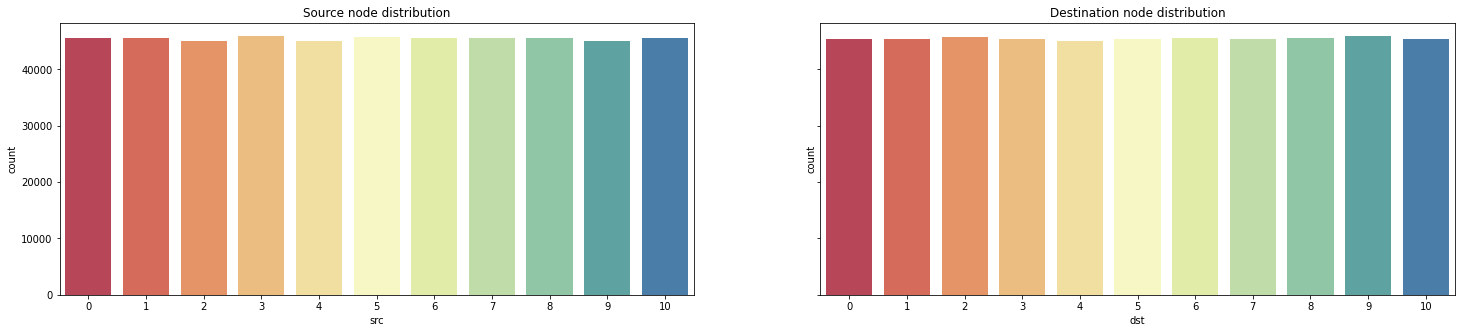

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(25,5))

sns.countplot(data=dataset, x="src", ax=ax1, palette="Spectral").set_title("Source node distribution")
sns.countplot(data=dataset, x="dst", ax=ax2, palette="Spectral").set_title("Destination node distribution")

From these plots, we see that the distribution of both source and destination nodes is fairly balanced across the network.

 Next, let's plot the distribution of node utilization, as well as maximum node utilization.

Text(0.5, 1.0, 'Node utilization')

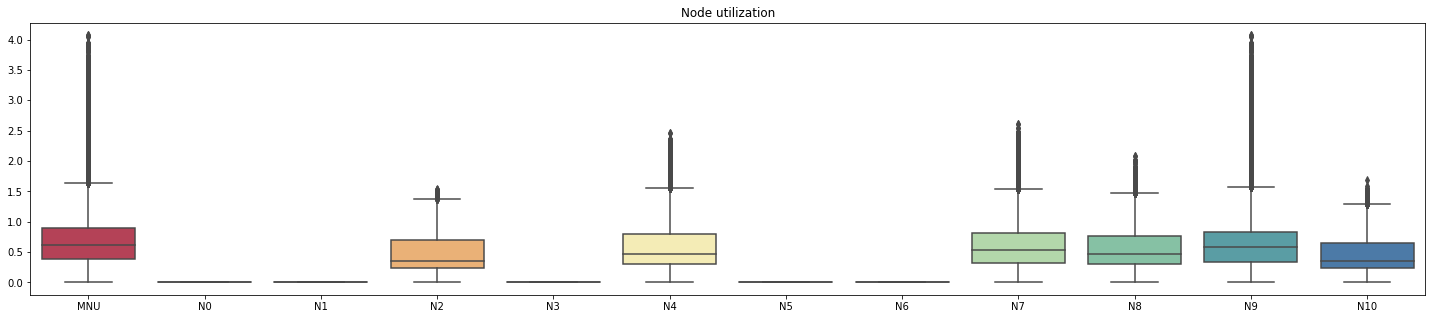

In [ ]:
plt.figure(figsize=(25,5))
sns.boxplot(data=dataset[["MNU", "N0", "N1", "N2", "N3", "N4", "N5", "N6", "N7", "N8", "N9", "N10"]], palette="Spectral").set_title('Node utilization')

These values represent the utilization of each node of the network. Values over 1 mean that the node doesn't have the capacity to handle all of the incoming requests. We see that the node with more pronounced outliers in the Node 9 (Atlanta), because this node supports the most services (4). Therefore, we see that the values of Maximum Node Utilization practically correspond to the values of N9. This means that MNU will be dependent and highly correlated to N9, and it is best to drop the MNU column.

Let's now analyze the boxplot of link utilization and maximum link utilization.

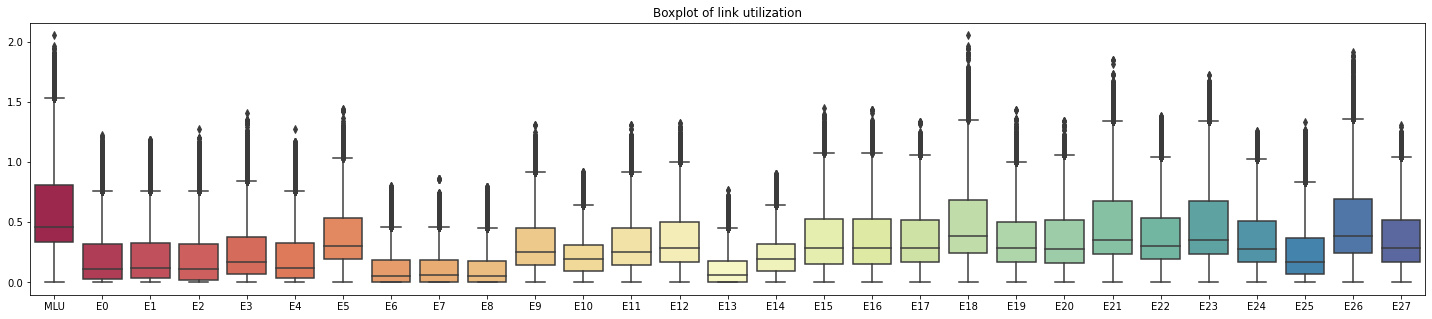

In [ ]:
plt.figure(figsize=(25, 5))
plt.title('Boxplot of link utilization')
sns.boxplot(data=dataset[["MLU", "E0", "E1", "E2", "E3", "E4", "E5", "E6", "E7", "E8", "E9", "E10", "E11", "E12", "E13", "E14", "E15", "E16", "E17", "E18", "E19", "E20", "E21", "E22", "E23", "E24", "E25", "E26", "E27"]], palette="Spectral")

Just like with node utilization, values over 1 represent overload. We see that MLU represents a mix of E18 and E26, which most likely are link that lead to N9. Once again, the MLU variable is dependent of the link utilization variables, and we have no interest in variable dependency.

Let's now plot the services requested, to see if there are services more popular than others.

Text(0.5, 1.0, 'S4 requested services')

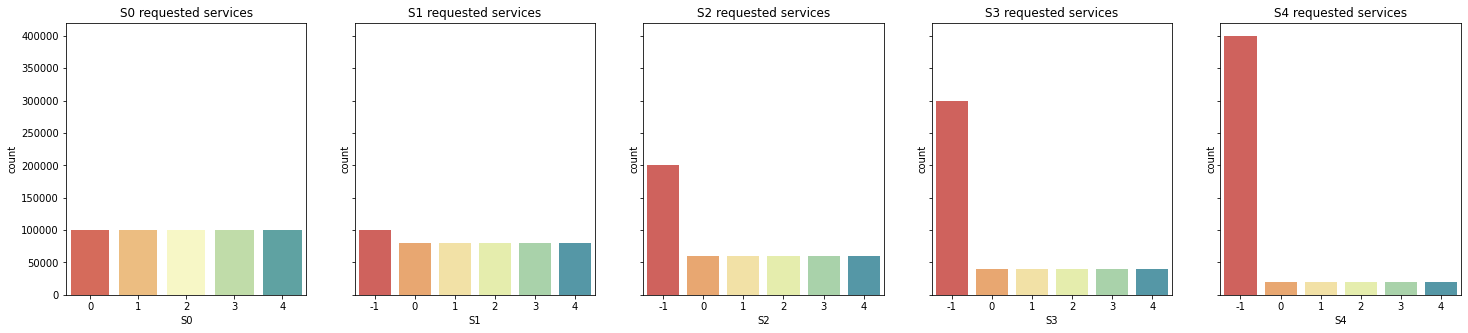

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, sharey=True, figsize=(25,5))
sns.countplot(data=dataset, x="S0", palette="Spectral", ax=ax1).set_title("S0 requested services")
sns.countplot(data=dataset, x="S1", palette="Spectral", ax=ax2).set_title("S1 requested services")
sns.countplot(data=dataset, x="S2", palette="Spectral", ax=ax3).set_title("S2 requested services")
sns.countplot(data=dataset, x="S3", palette="Spectral", ax=ax4).set_title("S3 requested services")
sns.countplot(data=dataset, x="S4", palette="Spectral", ax=ax5).set_title("S4 requested services")

We can see that the requested services are well balanced between the available services. The service denoted by -1 represents no service. This means that S0 will never have -1 values, because every request requires to have at least one service of interest. We can also see that we have a distribution of 100,000 requests per each category of requested services (1 to 5 services requested).

Let's now plot the assigned node per requested service.

Text(0.5, 1.0, 'Accumulated node assignments')

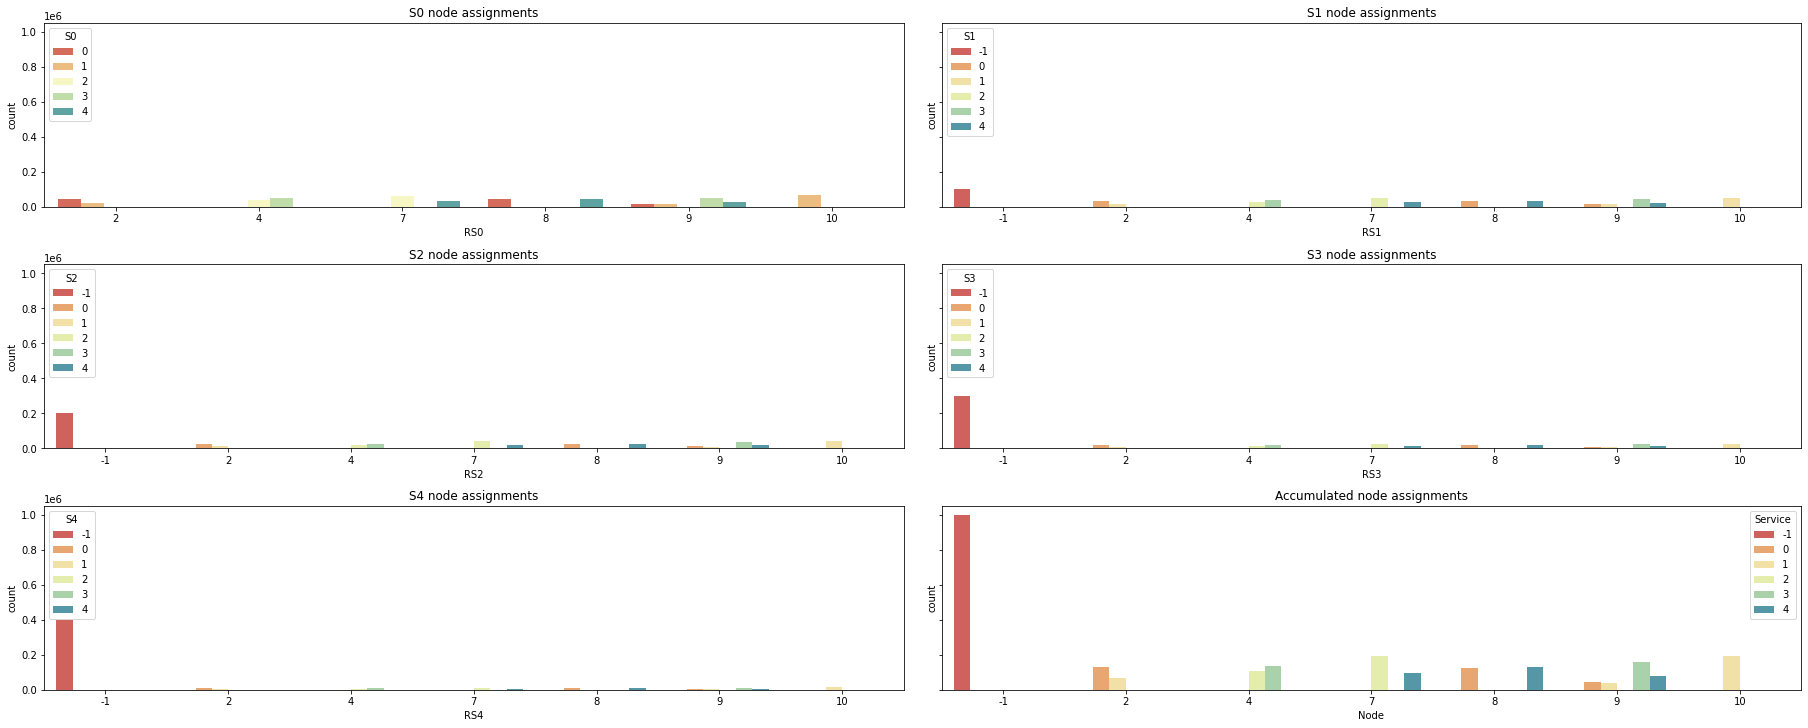

In [ ]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols=2, nrows=3, sharey=True, figsize=(25,10), constrained_layout=True)
sns.countplot(data=dataset, x="RS0", hue="S0", ax=ax1, palette="Spectral").set_title("S0 node assignments")
sns.countplot(data=dataset, x="RS1", hue="S1", ax=ax2, palette="Spectral").set_title("S1 node assignments")
sns.countplot(data=dataset, x="RS2", hue="S2", ax=ax3, palette="Spectral").set_title("S2 node assignments")
sns.countplot(data=dataset, x="RS3", hue="S3", ax=ax4, palette="Spectral").set_title("S3 node assignments")
sns.countplot(data=dataset, x="RS4", hue="S4", ax=ax5, palette="Spectral").set_title("S4 node assignments")

def fetchServiceAndNode(service, node):
  df = dataset[[service, node]]
  df.columns = ["Service", "Node"]
  return df

df_accumulated = pd.concat([fetchServiceAndNode("S{}".format(i), "RS{}".format(i)) for i in range(5)])
sns.countplot(data=df_accumulated, x="Node", hue="Service", ax=ax6, palette="Spectral").set_title("Accumulated node assignments")

Here we can see each nodes handle which service requests. Even though we know a priori which nodes are assigned to which services, there are multiple node capable of handling the same service, and it is relevant to know how these are distribuited. Per example, both nodes 2 and 9 can handle service 1 (WAN and application acceleration), but N2 handles more service 1 requests, probably because N9 handles a larger variaty of services than N2. 

Let's now see the final plots, regarding bandwidth and duration.

Text(0.5, 1.0, 'Duration distribution')

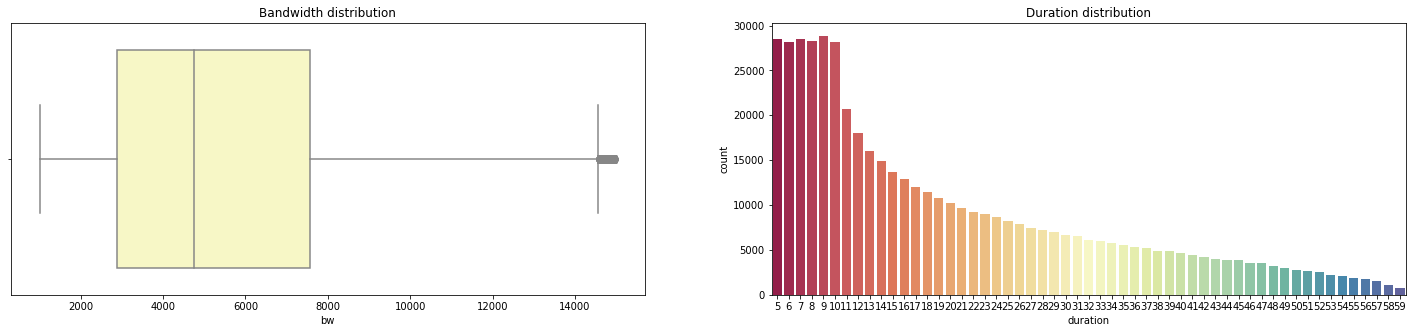

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(25,5))
sns.boxplot(data=dataset, x="bw", ax=ax1, palette="Spectral").set_title("Bandwidth distribution")
sns.countplot(data=dataset, x="duration", ax=ax2, palette="Spectral").set_title("Duration distribution")

Now, let's analyze the correlation matrix.

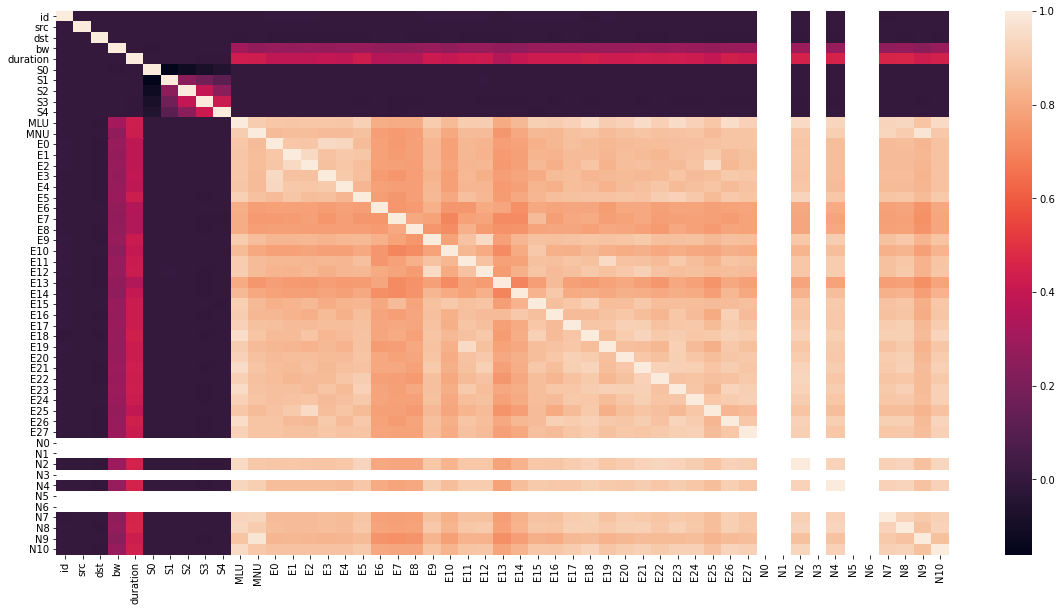

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(dataset.drop(columns=["RS0", "RS1", "RS2", "RS3", "RS4"]).corr())

We can see that the nodes N0, N1, N3, N5 and N6 do not contain any information, and therefore can be dropped. Also, like suspected, there is a high correlation between N9 and MNU. In general, there is a high correlation between node utilzation and link utilization, which makes sense. 

Now that we completed our data exploration, we can safely drop some of the columns. As discussed above, the nodes that don't handle services will be dropped because they contain no information, as well as MNU and MLU, which are just maximum values of other variables. Also, we can drop "id" as well, because it contains no more information than the number of the row of the observation. Let's then drop the refered column and take a look at the dataset once again.

In [ ]:
dataset = dataset.drop(columns=["id", "N0", "N1", "N3", "N5", "N6", "MNU", "MLU"])
dataset.head()

,src,dst,bw,duration,S0,S1,S2,S3,S4,E0,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E20,E21,E22,E23,E24,E25,E26,E27,N2,N4,N7,N8,N9,N10,RS0,RS1,RS2,RS3,RS4
0,2,5,7157.260627,29,2,4,3,-1,-1,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.0000,0.0000,0.000,0.0000,0.0000,7,7,4,-1,-1
1,0,7,1360.551508,25,2,-1,-1,-1,-1,0.0000,0.0,0.0,0.0000,0.0,0.0719,0.0,0.0,0.0,0.0719,0.0,0.0,0.0,0.0000,0.0719,0.0,0.0719,0.0000,0.0,0.0,0.0719,0.0000,0.0,0.0719,0.0000,0.0,0.0000,0.0,0.0,0.0716,0.1431,0.000,0.0000,0.0000,7,-1,-1,-1,-1
2,9,3,7592.258826,13,1,-1,-1,-1,-1,0.0137,0.0,0.0,0.0137,0.0,0.0719,0.0,0.0,0.0,0.0719,0.0,0.0,0.0,0.0000,0.0719,0.0,0.0719,0.0000,0.0,0.0,0.0719,0.0000,0.0,0.0719,0.0000,0.0,0.0137,0.0,0.0,0.0716,0.1568,0.000,0.0000,0.0000,9,-1,-1,-1,-1
3,10,10,13151.493039,28,2,0,4,3,1,0.0137,0.0,0.0,0.0137,0.0,0.0719,0.0,0.0,0.0,0.0719,0.0,0.0,0.0,0.0763,0.0719,0.0,0.1482,0.0000,0.0,0.0,0.0719,0.0000,0.0,0.0719,0.0763,0.0,0.0899,0.0,0.0,0.0716,0.1568,0.000,0.0759,0.0000,7,8,8,9,10
4,6,9,7830.801264,9,0,1,-1,-1,-1,0.0137,0.0,0.0,0.0137,0.0,0.0719,0.0,0.0,0.0,0.0719,0.0,0.0,0.0,0.0763,0.0719,0.0,0.1482,0.1321,0.0,0.0,0.0719,0.1321,0.0,0.0719,0.2084,0.0,0.2221,0.0,0.0,0.0716,0.2883,0.263,0.2074,0.1315,8,9,-1,-1,-1


# Prediction models using sklearn

Now that we know more about the dataset we are working with, we are ready to start to test some classifiers. The models must support multi-output classification, since we are looking to predict multiple variables withing a class (represented by nodes).

Let's define out train and test data. Since we have a relatively large dataset, we can be more generous in the training data.

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, test_size=0.05)
train_x, test_x = train.drop(columns=["RS0", "RS1", "RS2", "RS3", "RS4"]), test.drop(columns=["RS0", "RS1", "RS2", "RS3", "RS4"])
train_y, test_y = train[["RS0", "RS1", "RS2", "RS3", "RS4"]], test[["RS0", "RS1", "RS2", "RS3", "RS4"]]

The following code will be used to analyze model prediction performance, as it will be shown later on.

In [ ]:
from sklearn.metrics import confusion_matrix

# Display plots to analyze model performance
def checkPredictions(expectedValues, predictedValues):
  # Labels are node services, values that RS[0-4] can take
  labels = [-1,2,4,7,8,9,10]

  # Calculate confusion matrix for single output label
  def calculateSingleConfusionMatrix(label):
    expected, predicted = [item[label] for item in expectedValues], [item[label] for item in predictedValues]
    return confusion_matrix(expected, predicted, labels=labels)

  # Accuracy by requested service
  def generateAccuracyDf(label=-1):
    columns = ["Service", "Predicted"]
    rows = []

    for (expected, predicted) in list(zip(expectedValues, predictedValues)):
      if label == -1:
        for i in range(len(expected)):
          rows.append([expected[i], expected[i] == predicted[i]])

      else:
        rows.append([expected[label], expected[label] == predicted[label]])

    return pd.DataFrame(columns=columns, data=rows)

  # Calculates percentage of accurate predictions
  def accuracyDfToAccuracyRow(accuracyDf, label):
    labelString = "Accumulated" if label == -1 else "RS{}".format(label) 
    accuracy = np.sum(accuracyDf["Predicted"]) / len(accuracyDf["Predicted"])

    return [labelString, accuracy, True], [labelString, 1-accuracy, False]


  # Create matplotlib fig instances
  fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots(ncols=3, nrows=4, figsize=(20,10), constrained_layout=True)
  
  # Plot confusion matrices
  sns.heatmap(calculateSingleConfusionMatrix(0), xticklabels=labels, yticklabels=labels, annot=True, ax=ax1).set_title("RS0 Confusion Matrix")
  sns.heatmap(calculateSingleConfusionMatrix(1), xticklabels=labels, yticklabels=labels, annot=True, ax=ax2).set_title("RS1 Confusion Matrix")
  sns.heatmap(calculateSingleConfusionMatrix(2), xticklabels=labels, yticklabels=labels, annot=True, ax=ax3).set_title("RS2 Confusion Matrix")
  sns.heatmap(calculateSingleConfusionMatrix(3), xticklabels=labels, yticklabels=labels, annot=True, ax=ax4).set_title("RS3 Confusion Matrix")
  sns.heatmap(calculateSingleConfusionMatrix(4), xticklabels=labels, yticklabels=labels, annot=True, ax=ax5).set_title("RS4 Confusion Matrix")

  accuracyDfs = {i:generateAccuracyDf(i) for i in range(-1,5)}

  # Countplots of predictions
  sns.countplot(data=accuracyDfs[0], x="Predicted", hue="Service", ax=ax6, palette="magma").set_title("RS0 Prediction by Service")
  sns.countplot(data=accuracyDfs[1], x="Predicted", hue="Service", ax=ax7, palette="magma").set_title("RS1 Prediction by Service")
  sns.countplot(data=accuracyDfs[2], x="Predicted", hue="Service", ax=ax8, palette="magma").set_title("RS2 Prediction by Service")
  sns.countplot(data=accuracyDfs[3], x="Predicted", hue="Service", ax=ax9, palette="magma").set_title("RS3 Prediction by Service")
  sns.countplot(data=accuracyDfs[4], x="Predicted", hue="Service", ax=ax10, palette="magma").set_title("RS4 Prediction by Service")
  sns.countplot(data=accuracyDfs[-1], x="Predicted", hue="Service", ax=ax11, palette="magma").set_title("Accumulated Prediction by Service")


  # Generate global accuracy plot
  columns = ["Label", "Percentage", "Predicted"]
  rows = []

  # Calculate accuracy assuming all lables as one
  # This means that if one of them was predicted incorrectly, output is incorrect
  full_output_accuracy = np.sum(list(map(lambda x: np.array_equal(x[0], x[1]), list(zip(expectedValues, predictedValues))))) / len(expectedValues)
  rows.append(["Output", full_output_accuracy, True])
  rows.append(["Output", 1-full_output_accuracy, False])

  # -1 goes last so that accumulated individual accuracy goes last
  for i in list(range(0,5)) + [-1]:
    trues, falses = accuracyDfToAccuracyRow(accuracyDfs[i], i)
    rows.append(trues)
    rows.append(falses)

  df = pd.DataFrame(columns=columns, data=rows)
  sns.barplot(data=df, x="Label", y="Percentage", hue="Predicted", ax=ax12, palette="magma").set_title("Model Accuracies")

  print("Model output accuracy:", full_output_accuracy)

Check some models, man!

Model output accuracy: 0.03895


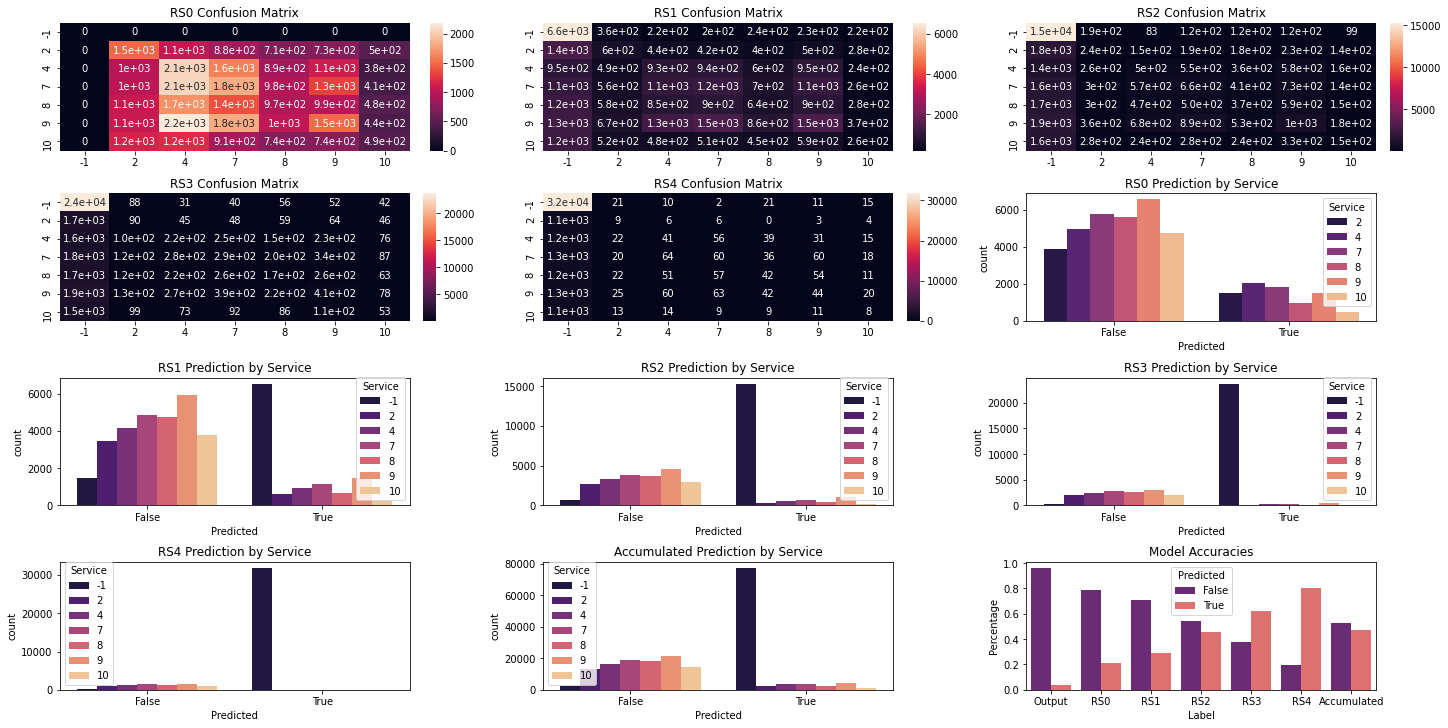

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(train_x.to_numpy(), train_y.to_numpy())
predictions = knn.predict(test_x.to_numpy())

checkPredictions(test_y.to_numpy(), predictions)

Model output accuracy: 0.4559


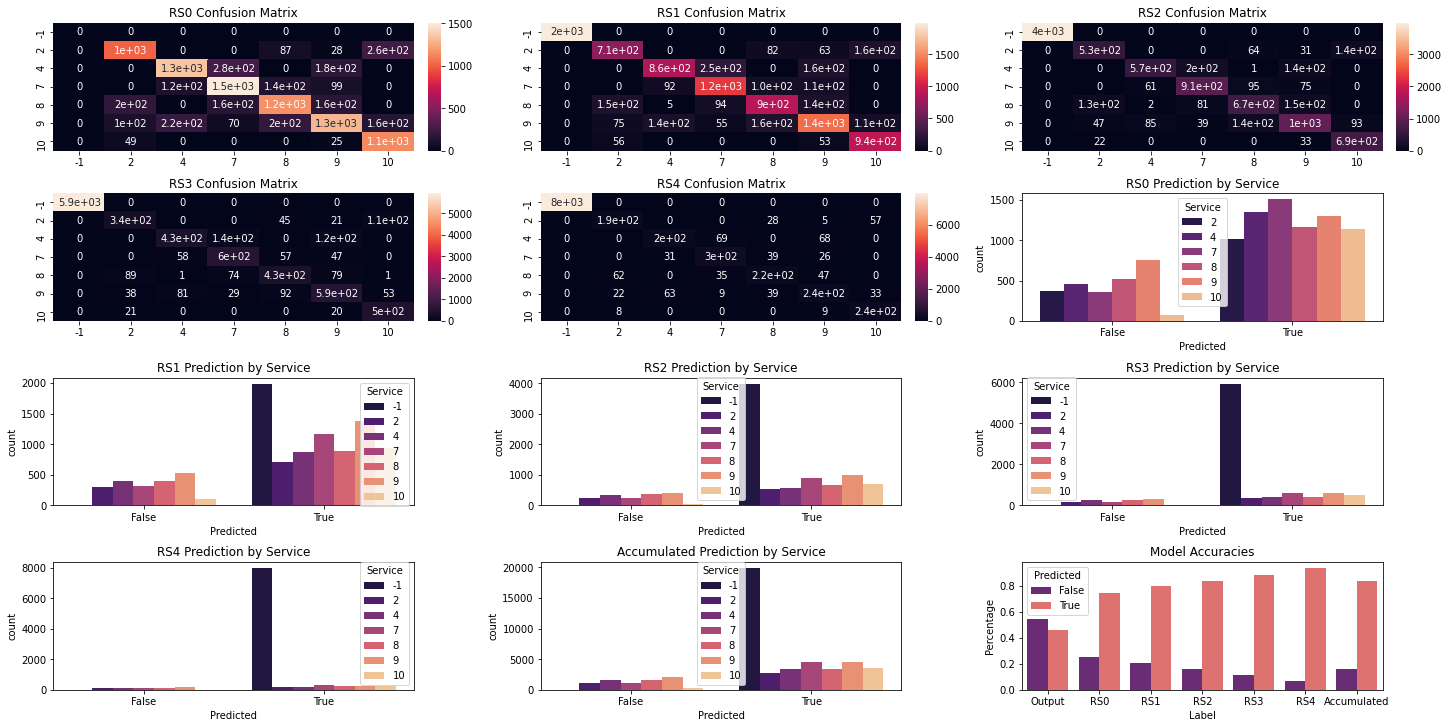

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_jobs=-1)
rfc.fit(train_x.to_numpy(), train_y.to_numpy())
predictions = rfc.predict(test_x.to_numpy())

checkPredictions(test_y.to_numpy(), predictions)

Model output accuracy: 0.0433


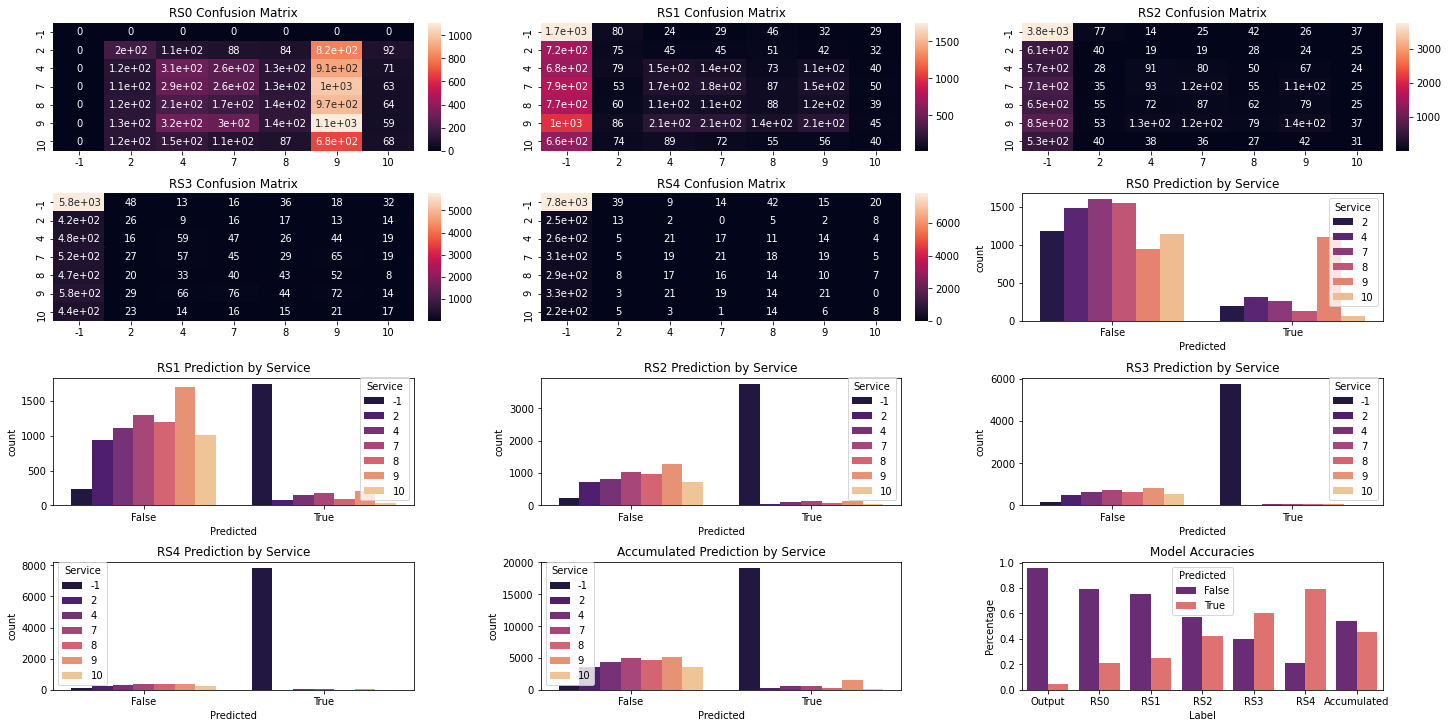

In [ ]:
from sklearn.neighbors import RadiusNeighborsClassifier

rnc = RadiusNeighborsClassifier(radius=5, outlier_label="most_frequent", n_jobs=-1)
rnc.fit(train_x.to_numpy(), train_y.to_numpy())
predictions = rnc.predict(test_x.to_numpy())

checkPredictions(test_y.to_numpy(), predictions)

Model output accuracy: 0.38544


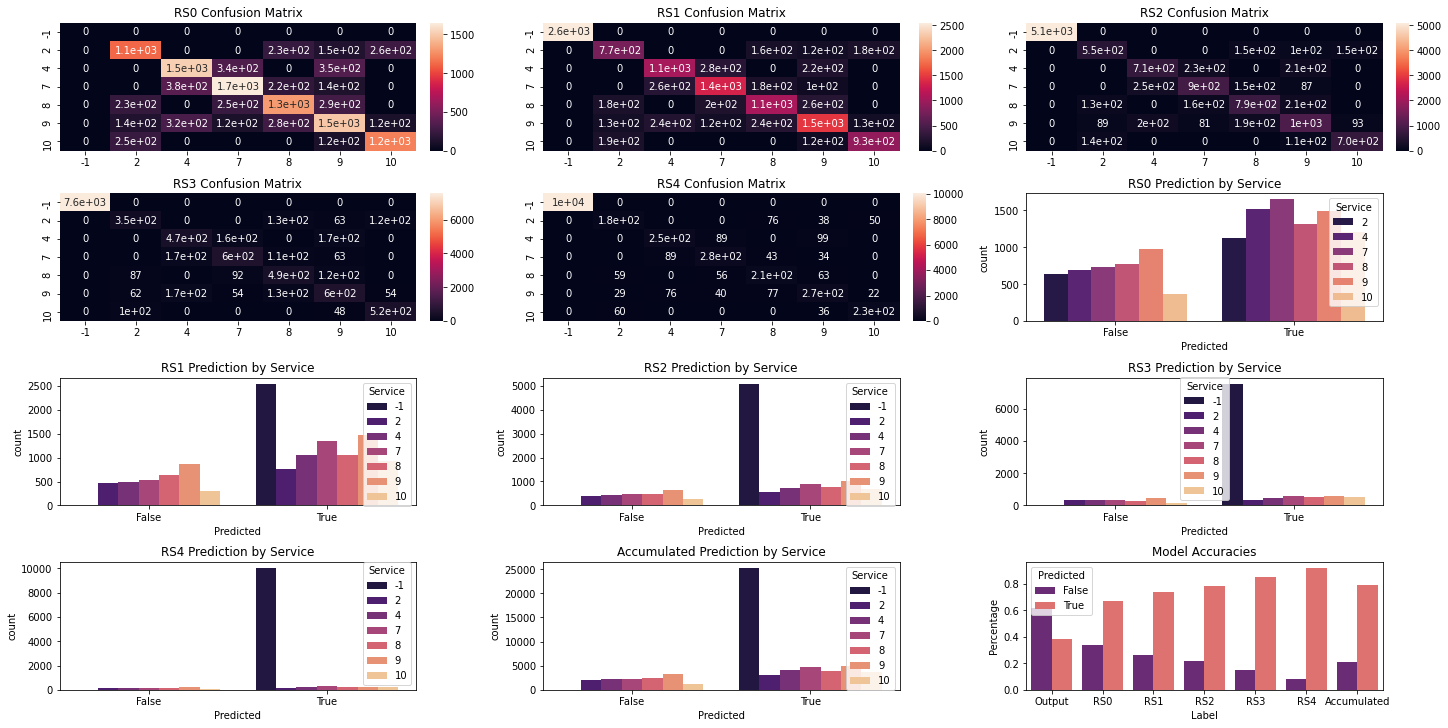

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(train_x.to_numpy(), train_y.to_numpy())
predictions = dtc.predict(test_x.to_numpy())

checkPredictions(test_y.to_numpy(), predictions)

Model output accuracy: 0.13792


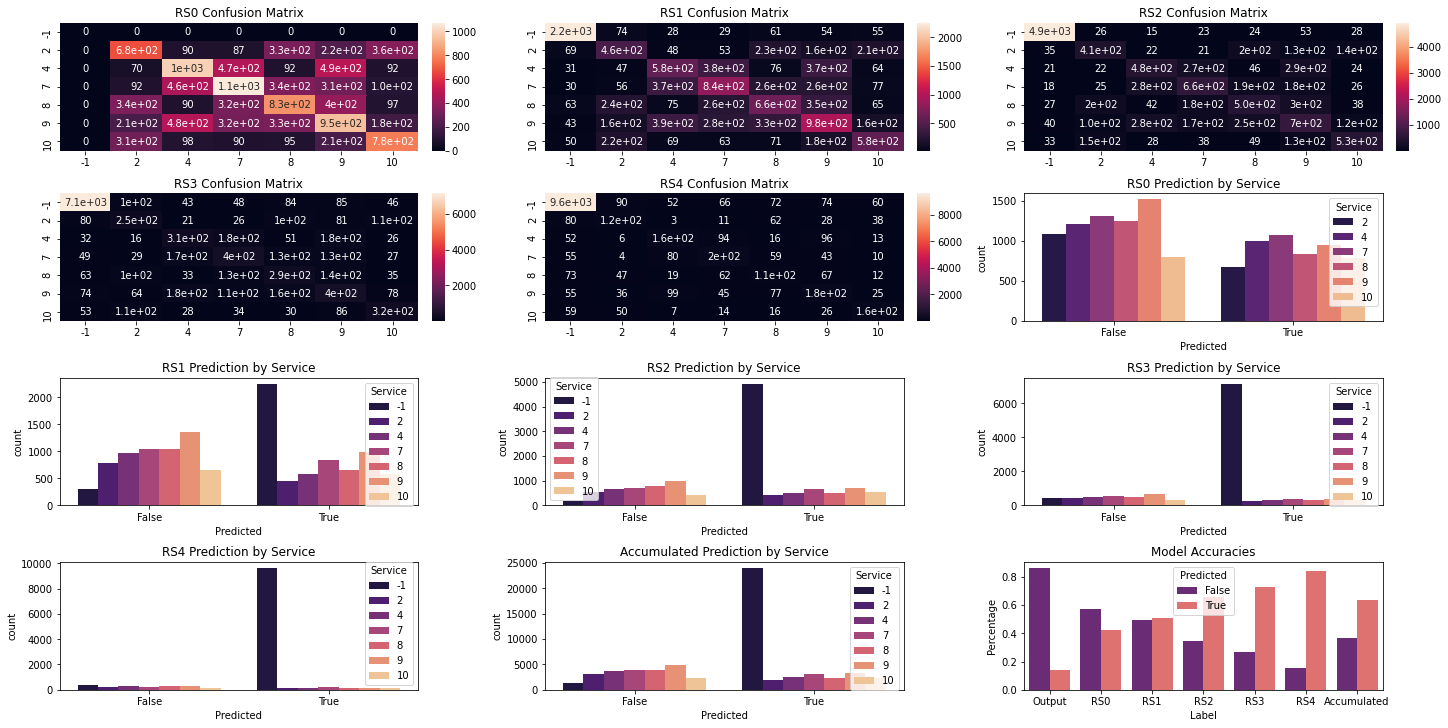

In [ ]:
from sklearn.tree import ExtraTreeClassifier

etc = ExtraTreeClassifier(random_state=0)
etc.fit(train_x.to_numpy(), train_y.to_numpy())
predictions = etc.predict(test_x.to_numpy())

checkPredictions(test_y.to_numpy(), predictions)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

etsc = ExtraTreesClassifier(random_state=0)
etsc.fit(train_x.to_numpy(), train_y.to_numpy())
predictions = etsc.predict(test_x.to_numpy())

checkPredictions(test_y.to_numpy(), predictions)